<a href="https://colab.research.google.com/github/grosetta/rdkit_study/blob/main/%E5%BE%AA%E7%8E%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#文件头代码
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.insert(0,"/content/gdrive/My Drive/Colab Notebooks/python_package/")

Mounted at /content/gdrive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt
import os

In [4]:
input_word = "abcde"
w_to_id = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}  # 单词映射到数值id的词典
id_to_onehot = {0: [1., 0., 0., 0., 0.], 1: [0., 1., 0., 0., 0.], 2: [0., 0., 1., 0., 0.], 3: [0., 0., 0., 1., 0.], 4: [0., 0., 0., 0., 1.]}  # id编码为one-hot

In [5]:
x_train = [id_to_onehot[w_to_id['a']], id_to_onehot[w_to_id['b']], id_to_onehot[w_to_id['c']],
           id_to_onehot[w_to_id['d']], id_to_onehot[w_to_id['e']]]
y_train = [w_to_id['b'], w_to_id['c'], w_to_id['d'], w_to_id['e'], w_to_id['a']]

In [6]:
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

In [7]:
# 使x_train符合SimpleRNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为len(x_train)；输入1个字母出结果，循环核时间展开步数为1; 表示为独热码有5个输入特征，每个时间步输入特征个数为5
x_train = np.reshape(x_train, (len(x_train), 1, 5))
y_train = np.array(y_train)

In [9]:
# 模型搭建
model = tf.keras.Sequential([
    SimpleRNN(3),  # 记忆体个数越多，记忆力越好，但是同时占用资源会更多
    Dense(5, activation='softmax')
])

In [10]:
# 模型优化
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [12]:
# 保存检查点文件路径
checkpoint_save_path = "./checkpoint/rnn_onehot_1pre1.ckpt"
# 如果存在检查点文件，读入文件信息
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                         save_weights_only=True,
                         save_best_only=True,
                         monitor='loss')  # 由于fit没有给出测试集，不计算测试集准确率，根据loss，保存最优模型


# 开始训练
history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=[cp_callback])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 3)                 27        
                                                                 
 dense_1 (Dense)             (None, 5)                 20        
                                                                 
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________


In [17]:
file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

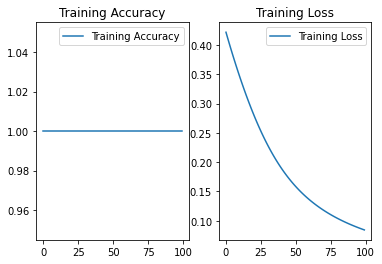

In [18]:
# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [24]:
# 预测
preNum = int(input("input the number of test alphabet:"))
for i in range(preNum):
    alphabet1 = input("input test alphabet:")
    alphabet = [id_to_onehot[w_to_id[alphabet1]]]
    # 使alphabet符合SimpleRNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。此处验证效果送入了1个样本，送入样本数为1；输入1个字母出结果，所以循环核时间展开步数为1; 表示为独热码有5个输入特征，每个时间步输入特征个数为5
    alphabet = np.reshape(alphabet, (1, 1, 5))
    result = model.predict([alphabet])
    pred = tf.argmax(result, axis=1)
    pred = int(pred)
    tf.print(alphabet1 + '->' + input_word[pred])

input the number of test alphabet:2
input test alphabet:a
1/1 [==============================] - 0s 17ms/step
a->b
input test alphabet:b
1/1 [==============================] - 0s 18ms/step
b->c
